In [ ]:
!pip -q install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.layers import  Dense,Dropout,Input
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestRegressor
import xgboost as xg

In [ ]:
params=pd.read_fwf('latin_hypercube_params.txt')
#!unzip -qq latin_hypercube_nwLH.zip

In [ ]:
params.rename(columns={"# Omega_m": "Omega_m"},inplace=True)

In [ ]:
#DataFrame with the cosmological parameters of the simulations
params

,Omega_m,Omega_b,h,n_s,sigma_8,M_nu,w
0,0.2137,0.05715,0.6499,0.8365,0.9489,0.213693,-1.08325
1,0.4281,0.04973,0.7191,1.1063,0.6489,0.949758,-0.94375
2,0.3399,0.05495,0.7463,1.1263,0.9823,0.721067,-1.17955
3,0.2795,0.03025,0.8807,1.0819,0.7275,0.751757,-1.06255
4,0.4505,0.05241,0.6489,0.9415,0.8545,0.250323,-0.87325
...,...,...,...,...,...,...,...
1995,0.3205,0.04161,0.5193,1.0817,0.6649,0.377043,-0.96145
1996,0.1693,0.04009,0.7745,1.0985,0.7457,0.420602,-1.02355
1997,0.4853,0.03785,0.6403,0.8503,0.7771,0.669092,-1.08265
1998,0.2607,0.04169,0.6861,0.8983,0.9689,0.291407,-0.85105


In [ ]:
#Normalise the data
params['Omega_m'] =(params['Omega_m']-0.1)/(0.5-0.1)
params['Omega_b'] =(params['Omega_b']-0.03)/(0.07-0.03)
params['h']       =(params['h']-0.5)/(0.9-0.5)
params['n_s']     =(params['n_s']-0.8)/(1.2-0.8)
params['sigma_8'] =(params['sigma_8']-0.6)/(1-0.6)
params['M_nu']    =(params['M_nu']-0.01)/(1-0.01)
params['w']       =(params['w']+1.3)/(-0.7+1.3)

In [ ]:
# Choose the min and max values of k for training
imin=1;imax=286;

In [ ]:
# Read the data files
psa=[]
for i in range(2000):
    df=pd.read_fwf('latin_hypercube_nwLH/'+str(i)+'/Pk_m_z=0.txt',header=None)
    psa.append(df.iloc[imin:imax,1].values)
ps=np.array(psa)

Text(0, 0.5, 'P(k)')

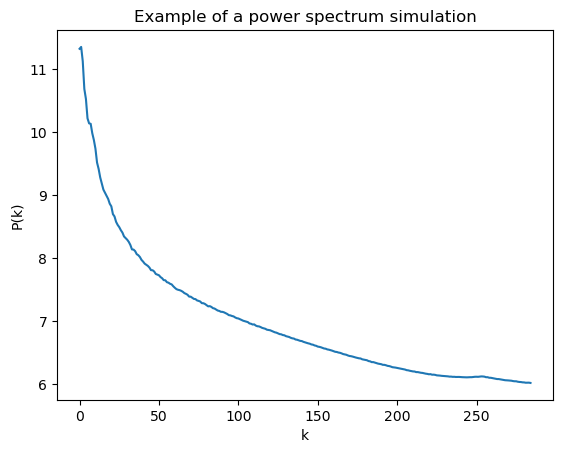

In [ ]:
# Power specturm example
df=pd.read_fwf('latin_hypercube_nwLH/0/Pk_m_z=0.txt',header=None)
kvals=df.iloc[imin:imax,0].values
y1=df.iloc[imin:imax,1]
y2=np.log(df.iloc[imin:imax,1].values)
plt.plot(y2)
plt.title('Example of a power spectrum simulation')
plt.xlabel('k')
plt.ylabel('P(k)')

In [ ]:
# Neural Networks

In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(params, np.log(ps), test_size=0.05, random_state=66)

In [ ]:
# Set up K-Fold Cross-Validation for training the neural networks
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

**Neural networks**

In [ ]:
def model_NN():
    tf.random.set_seed(87)
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(7,)))
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(285, activation='linear'))

    model.compile(loss='mse',
             optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
             metrics=['mse']
             )

    return model

In [ ]:
def model_NN_PCA():
    modelPCA = tf.keras.models.Sequential()
    modelPCA.add(Input(shape=(7,)))
    modelPCA.add(Dense(2048, activation='relu'))
    modelPCA.add(Dropout(0.6))
    modelPCA.add(Dense(2048, activation='relu'))
    modelPCA.add(Dropout(0.6))
    modelPCA.add(Dense(11, activation='linear'))

    modelPCA.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['mse'])

    return modelPCA

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=125, restore_best_weights=True)

In [ ]:
y_pred_NN_all=np.zeros((5,100,285))
y_pred_NN_PCA_all=np.zeros((5,100,285))

#val_mse_per_fold = []

for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f'Fold {fold + 1}')

    # Split the data into training and validation sets for this fold
    X_train_fold, X_val_fold = np.array(X_train)[train_index], np.array(X_train)[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    #PCA
    pca = PCA(n_components=11)
    y_train_pca_fold  = pca.fit_transform(y_train_fold)
    y_val_pca_fold    = pca.transform(y_val_fold)
    y_test_pca_fold   = pca.transform(y_test)

    # Create a new instance of the model for each fold
    model = model_NN()
    modelPCA = model_NN_PCA()

    print('Neural network')

    # Train the model on the training fold
    model.fit(X_train_fold,y_train_fold, validation_data=(X_val_fold, y_val_fold) ,epochs=3000, callbacks=[early_stopping],verbose=0)
    # Evaluate the model on the validation fold
    y_pred_NN_all[fold]=model.predict(X_test)

    print('Neural network (PCA)')
    # Train the model on the training fold

    modelPCA.fit(X_train_fold,y_train_pca_fold, validation_data=(X_val_fold, y_val_pca_fold) ,epochs=3000, callbacks=[early_stopping],verbose=0)
    # Evaluate the model on the validation fold
    predsPCA_NN=modelPCA.predict(X_test)
    y_pred_NN_PCA_all[fold]=pca.inverse_transform(predsPCA_NN)



In [ ]:
# Average between folds
y_pred_NN=np.mean(y_pred_NN_all,axis=0)
y_pred_NN_PCA=np.mean(y_pred_NN_PCA_all,axis=0)

**CatBoost**

In [ ]:
# CatBoost
model_CB = CatBoostRegressor(loss_function='MultiRMSE',iterations=5000,verbose=0)
model_CB.fit(X_train, y_train)
y_pred_CB = model_CB.predict(X_test)

In [ ]:
# CatBoost PCA
pca = PCA(n_components=11)
y_train_pca_cb  = pca.fit_transform(y_train)


model_CB_PCA = CatBoostRegressor(loss_function='MultiRMSE',iterations=5000,verbose=0)
model_CB_PCA.fit(X_train, y_train_pca_cb)
preds_CB_PCA = model_CB_PCA.predict(X_test)
y_pred_CB_PCA = pca.inverse_transform(preds_CB_PCA)

In [ ]:
# Overall RMSE
print('Neural network:',"{:e}".format(root_mean_squared_error(np.exp(y_test),np.exp(y_pred_NN))))
print('Neural Network PCA:',"{:e}".format(root_mean_squared_error(np.exp(y_test),np.exp(y_pred_NN_PCA))))
print('CatBoost:',"{:e}".format(root_mean_squared_error(np.exp(y_test),np.exp(y_pred_CB))))
print('CatBoost PCA:',"{:e}".format(root_mean_squared_error(np.exp(y_test),np.exp(y_pred_CB_PCA))))

Neural network: 4.308122e+02
Neural Network PCA: 3.584239e+02
CatBoost: 5.559218e+02
CatBoost PCA: 5.821802e+02


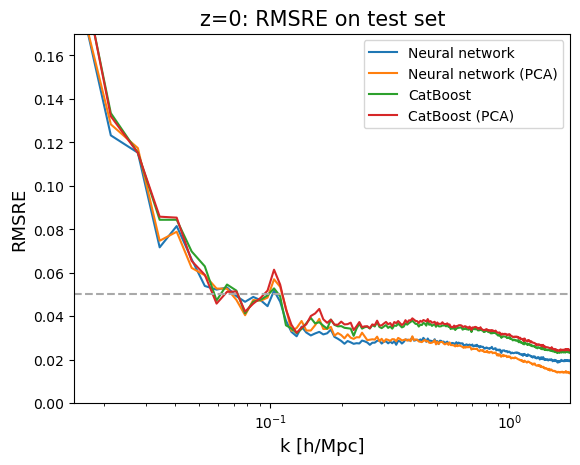

In [ ]:
rmse_NN=root_mean_squared_error((np.exp(y_pred_NN)/np.exp(y_test)),np.ones((100,285)),multioutput='raw_values')
rmse_NN_PCA=root_mean_squared_error((np.exp(y_pred_NN_PCA)/np.exp(y_test)),np.ones((100,285)),multioutput='raw_values')

rmse_CB=root_mean_squared_error((np.exp(y_pred_CB)/np.exp(y_test)),np.ones((100,285)),multioutput='raw_values')
rmse_CB_PCA=root_mean_squared_error((np.exp(y_pred_CB_PCA)/np.exp(y_test)),np.ones((100,285)),multioutput='raw_values')


plt.semilogx(kvals,rmse_NN,label='Neural network')
plt.semilogx(kvals,rmse_NN_PCA,label='Neural network (PCA)')
plt.semilogx(kvals,rmse_CB,label='CatBoost')
plt.semilogx(kvals,rmse_CB_PCA,label='CatBoost (PCA)')


plt.semilogx(kvals,0.05*np.ones(len(kvals)),'darkgrey',linestyle='--')
#plt.semilogx(kvals,0.03*np.ones(len(kvals)),'darkgrey',linestyle='--')
plt.legend()
plt.xlabel('k [h/Mpc]',fontsize=13)
plt.ylabel('RMSRE',fontsize=13)
plt.title('z=0: RMSRE on test set',fontsize=15)

plt.xlim((kvals[0],kvals[-1]))
plt.ylim((0,0.17))
plt.show()

In [ ]:
np.savez('arrays_z_0.npz', y_test, y_pred_NN, y_pred_NN_PCA, y_pred_CB, y_pred_CB_PCA)

**Random Forest Regressor**

In [ ]:
pca = PCA(n_components=11)
y_train_pca_rf  = pca.fit_transform(y_train)
y_test_pca_rf  = pca.fit_transform(y_test)


regr_rf = RandomForestRegressor(n_estimators=5000, verbose=0)
regr_rf.fit(X_train, y_train_pca_rf)
preds_RF_pca=regr_rf.predict(X_test)
y_pred_RF_PCA = pca.inverse_transform(preds_RF_pca)


**LightGBM**

In [ ]:
from sklearn.multioutput import MultiOutputRegressor

regr_lgbm = MultiOutputRegressor(LGBMRegressor(n_estimators=5000,verbose=0))
regr_lgbm.fit(X_train, y_train_pca_rf)
preds_lgbm_pca=regr_lgbm.predict(X_test)
y_pred_lgbm_PCA = pca.inverse_transform(preds_lgbm_pca)

**XGBoost**

In [ ]:
regr_xgb = xg.XGBRegressor(n_estimators=5000)
regr_xgb.fit(X_train, y_train_pca_rf)
preds_xgb_pca=regr_xgb.predict(X_test)
y_pred_xgb_PCA = pca.inverse_transform(preds_xgb_pca)

In [ ]:
np.savez('arrays_z_0_all.npz', y_test=y_test, y_pred_NN=y_pred_NN, y_pred_NN_PCA=y_pred_NN_PCA, y_pred_CB=y_pred_CB, y_pred_CB_PCA=y_pred_CB_PCA,y_pred_cv_CB_PCA=y_pred_cv_CB_PCA,y_pred_RF_PCA=y_pred_RF_PCA,y_pred_lgbm_PCA=y_pred_lgbm_PCA,y_pred_xgb_PCA=y_pred_xgb_PCA)

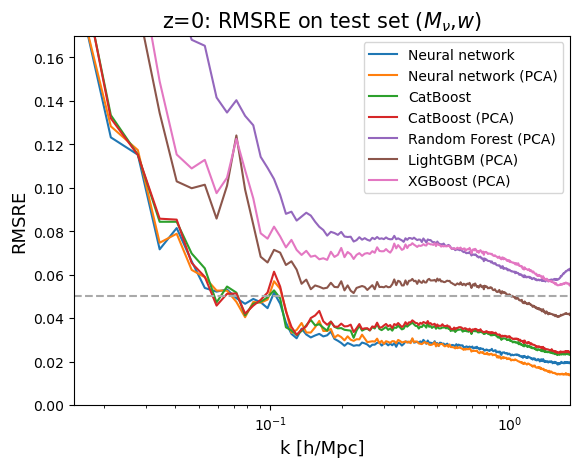

In [ ]:
rmse_NN=root_mean_squared_error((np.exp(y_pred_NN)/np.exp(y_test)),np.ones((100,285)),multioutput='raw_values')
rmse_NN_PCA=root_mean_squared_error((np.exp(y_pred_NN_PCA)/np.exp(y_test)),np.ones((100,285)),multioutput='raw_values')

rmse_CB=root_mean_squared_error((np.exp(y_pred_CB)/np.exp(y_test)),np.ones((100,285)),multioutput='raw_values')
rmse_CB_PCA=root_mean_squared_error((np.exp(y_pred_CB_PCA)/np.exp(y_test)),np.ones((100,285)),multioutput='raw_values')

rmse_cv_CB_PCA=root_mean_squared_error((np.exp(y_pred_cv_CB_PCA)/np.exp(y_test)),np.ones((100,285)),multioutput='raw_values')
rmse_RF_PCA=root_mean_squared_error((np.exp(y_pred_RF_PCA)/np.exp(y_test)),np.ones((100,285)),multioutput='raw_values')
rmse_lgbm_PCA=root_mean_squared_error((np.exp(y_pred_lgbm_PCA)/np.exp(y_test)),np.ones((100,285)),multioutput='raw_values')
rmse_xgb_PCA=root_mean_squared_error((np.exp(y_pred_xgb_PCA)/np.exp(y_test)),np.ones((100,285)),multioutput='raw_values')


plt.semilogx(kvals,rmse_NN,label='Neural network')
plt.semilogx(kvals,rmse_NN_PCA,label='Neural network (PCA)')
plt.semilogx(kvals,rmse_CB,label='CatBoost')
plt.semilogx(kvals,rmse_CB_PCA,label='CatBoost (PCA)')
plt.semilogx(kvals,rmse_RF_PCA,label='Random Forest (PCA)')
plt.semilogx(kvals,rmse_lgbm_PCA,label='LightGBM (PCA)')
plt.semilogx(kvals,rmse_xgb_PCA,label='XGBoost (PCA)')


plt.semilogx(kvals,0.05*np.ones(len(kvals)),'darkgrey',linestyle='--')
plt.legend()
plt.xlabel('k [h/Mpc]',fontsize=13)
plt.ylabel('RMSRE',fontsize=13)
plt.title(r'z=0: RMSRE on test set ($M_{\nu}$,$w$)',fontsize=15)

plt.xlim((kvals[0],kvals[-1]))
plt.ylim((0,0.17))
plt.savefig('mnu_z0_comp.pdf')
plt.show()